In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.utils import resample

warnings.filterwarnings("ignore")

## Load datasets

In [2]:
saheart = pd.read_csv("SAheart.data").drop(columns=["row.names"], axis=1)
saheart["famhist"] = LabelEncoder().fit_transform(saheart["famhist"])
saheart.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [3]:
saheart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    int32  
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int32(1), int64(4)
memory usage: 34.4 KB


In [4]:
fitness = pd.read_csv("fitness.txt", sep=" ")
fitness.head()

,Age,Weight,Oxygen,RunTime,RestPulse,RunPulse,MaxPulse
0,44,89.47,44.609,11.37,62,178,182
1,44,85.84,54.297,8.65,45,156,168
2,38,89.02,49.874,9.22,55,178,180
3,40,75.98,45.681,11.95,70,176,180
4,44,81.42,39.442,13.08,63,174,176


In [5]:
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        31 non-null     int64  
 1   Weight     31 non-null     float64
 2   Oxygen     31 non-null     float64
 3   RunTime    31 non-null     float64
 4   RestPulse  31 non-null     int64  
 5   RunPulse   31 non-null     int64  
 6   MaxPulse   31 non-null     int64  
dtypes: float64(3), int64(4)
memory usage: 1.8 KB


### Train test split

In [6]:
X_saheart = saheart.drop(columns=["chd"], axis=1)
y_saheart = saheart["chd"]

X_train_saheart, X_test_saheart, y_train_saheart, y_test_saheart = train_test_split(X_saheart, y_saheart, test_size=0.2, shuffle=True)

X_fitness = fitness.drop(columns=["Oxygen"], axis=1)
y_fitness = fitness["Oxygen"]

X_train_fitness, X_test_fitness, y_train_fitness, y_test_fitness = train_test_split(X_fitness, y_fitness, test_size=0.2, shuffle=True)

## DecisionTreeClassifier

#### max_depth

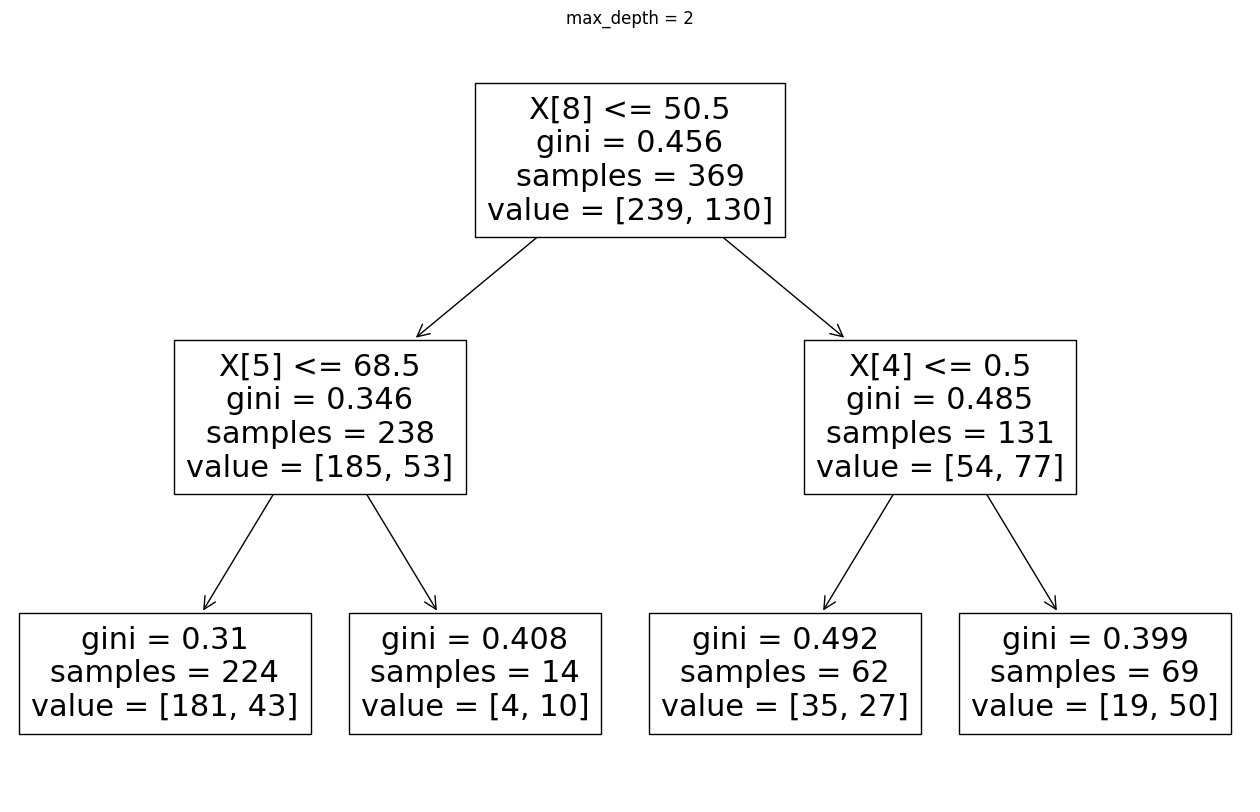

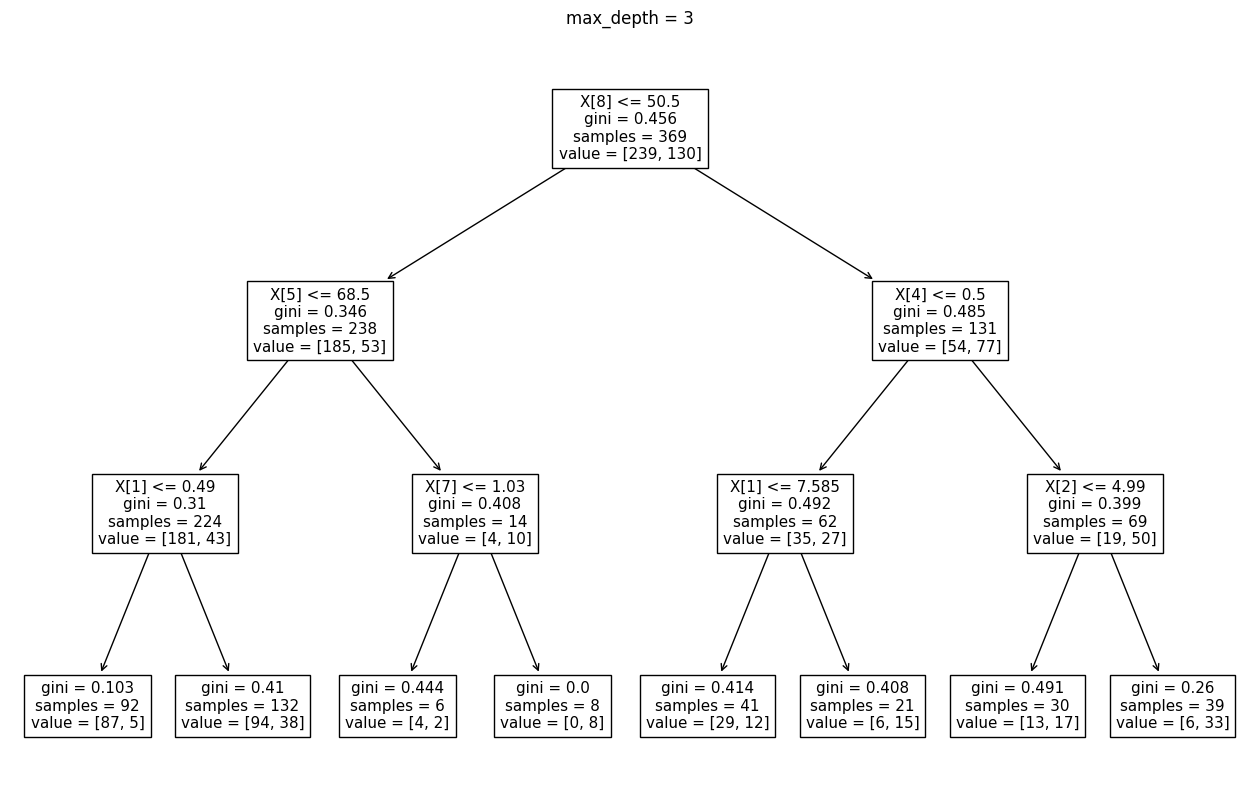

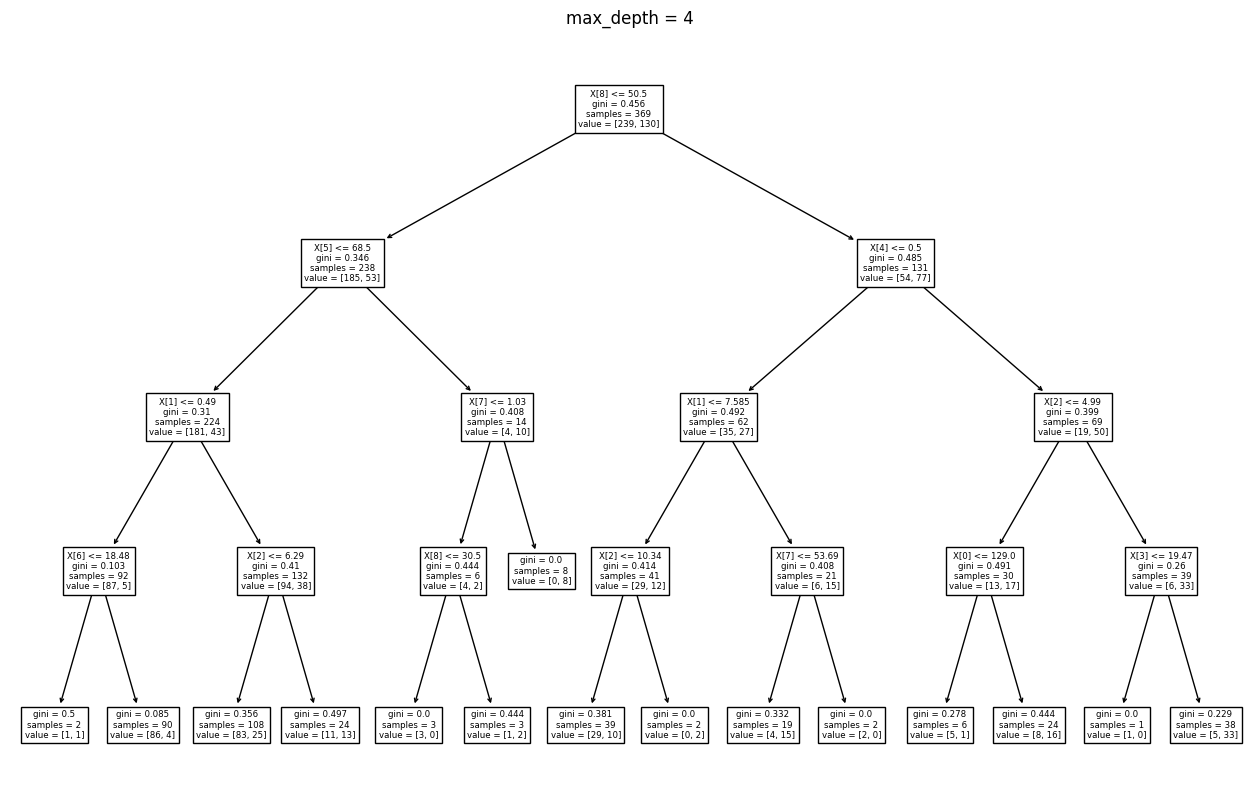

In [7]:
max_depths = [2, 3, 4]

for max_depth in max_depths:
    dtc = DecisionTreeClassifier(max_depth=max_depth)
    dtc.fit(X_train_saheart, y_train_saheart)

    plt.figure(figsize=(16, 10))
    plot_tree(dtc)
    plt.title(f"{max_depth = }")
    plt.show()

We can see that mex depth influence the depth of the splits in tree

#### min_samples_split

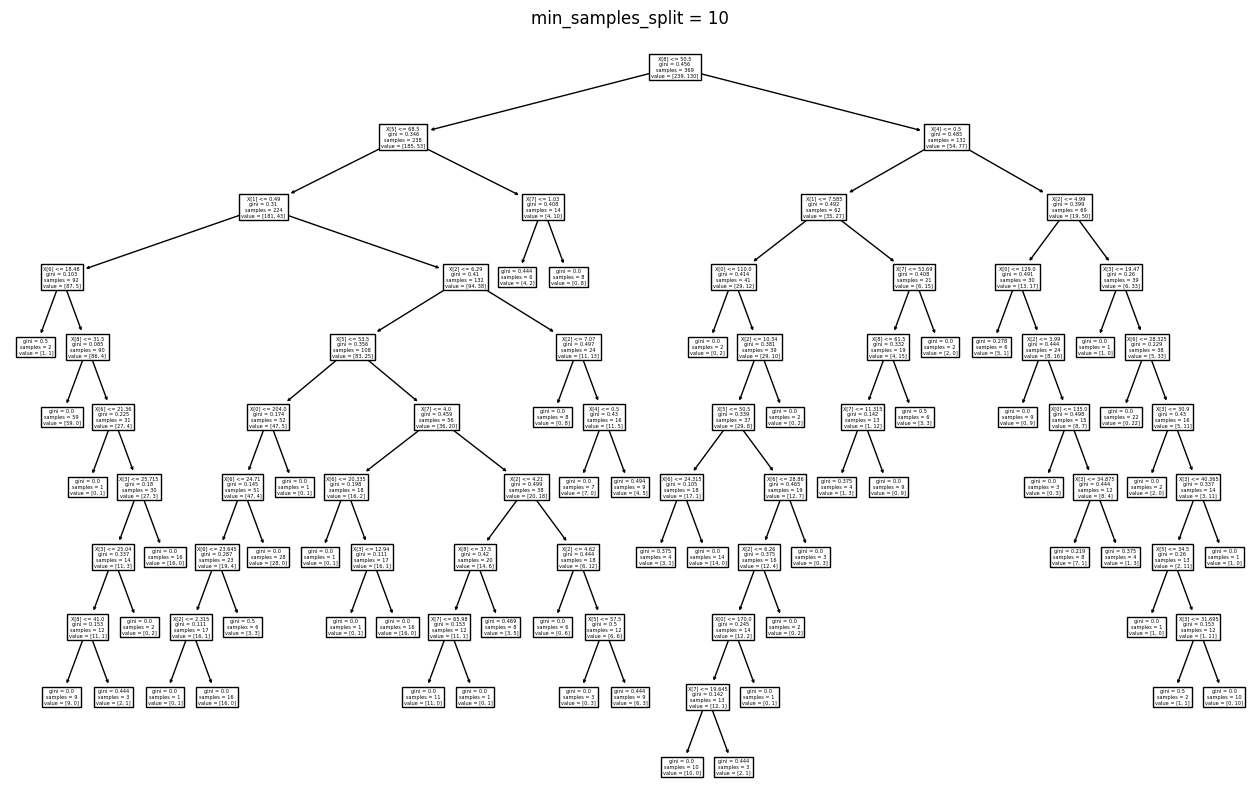

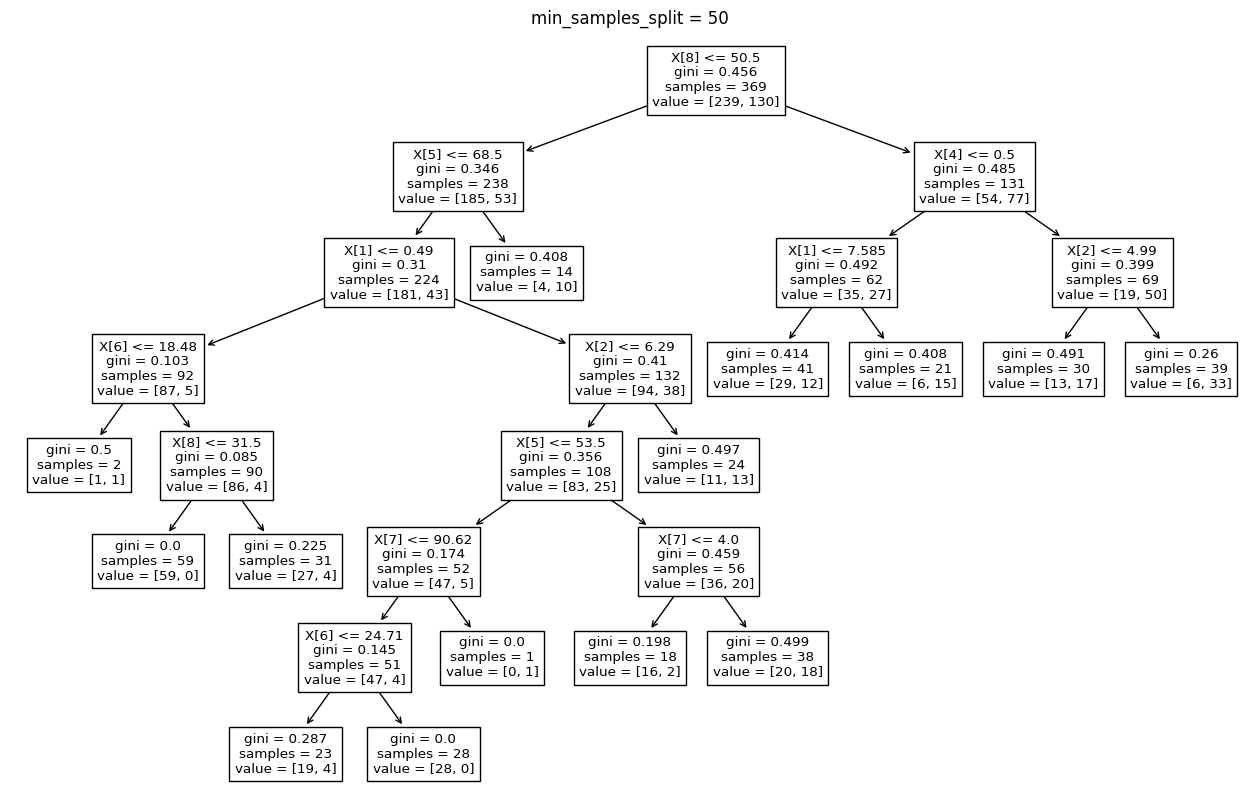

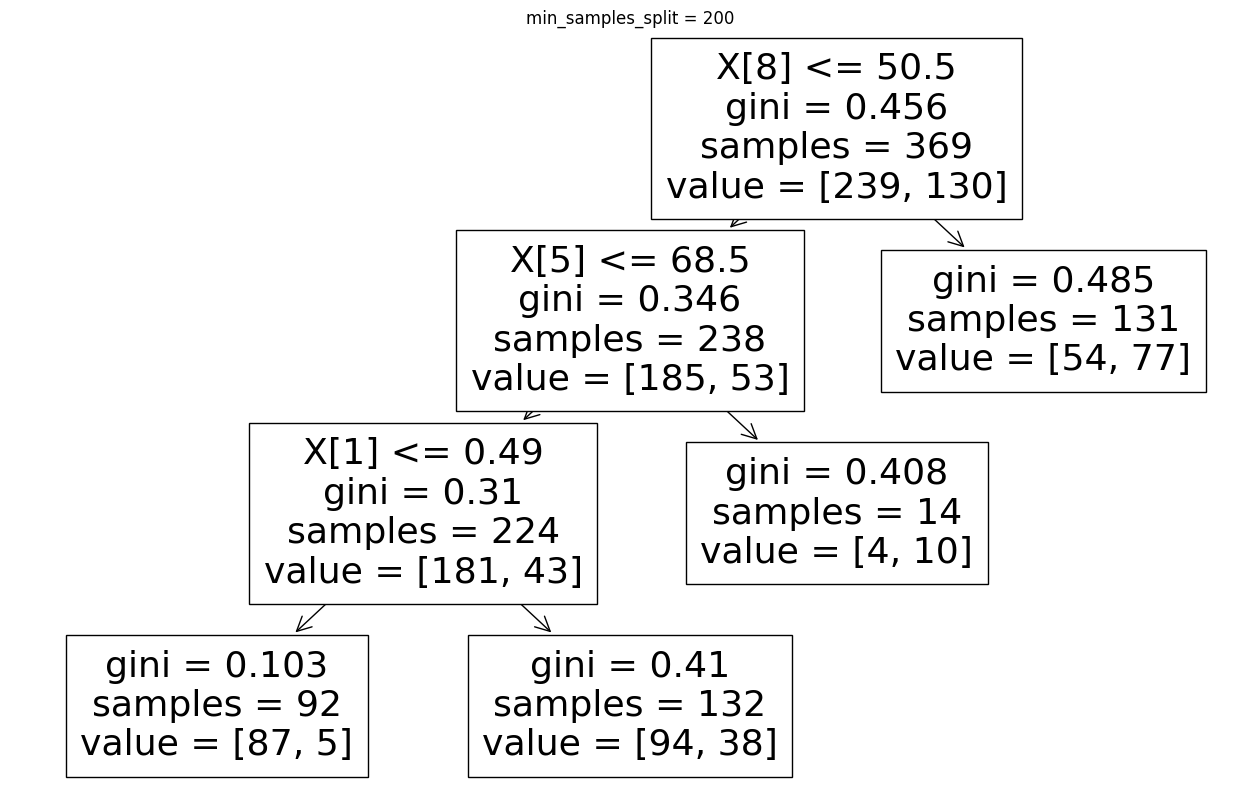

In [8]:
min_samples_splits = [10, 50, 200]

for min_samples_split in min_samples_splits:
    dtc = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dtc.fit(X_train_saheart, y_train_saheart)
    
    plt.figure(figsize=(16, 10))
    plot_tree(dtc)
    plt.title(f"{min_samples_split = }")
    plt.show()

This parameter influence the minimum number of samples required to split an internal node. We can see that smaller the value is then more nodes we have

#### criterion

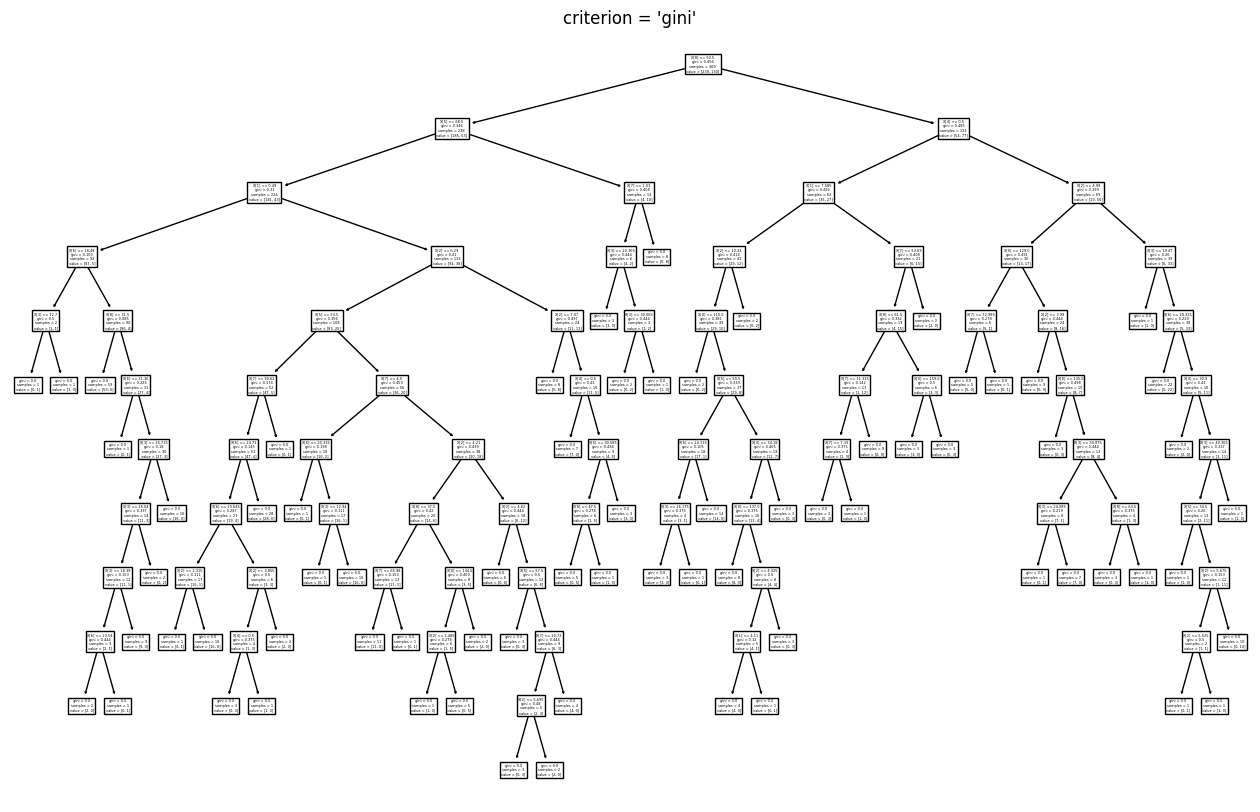

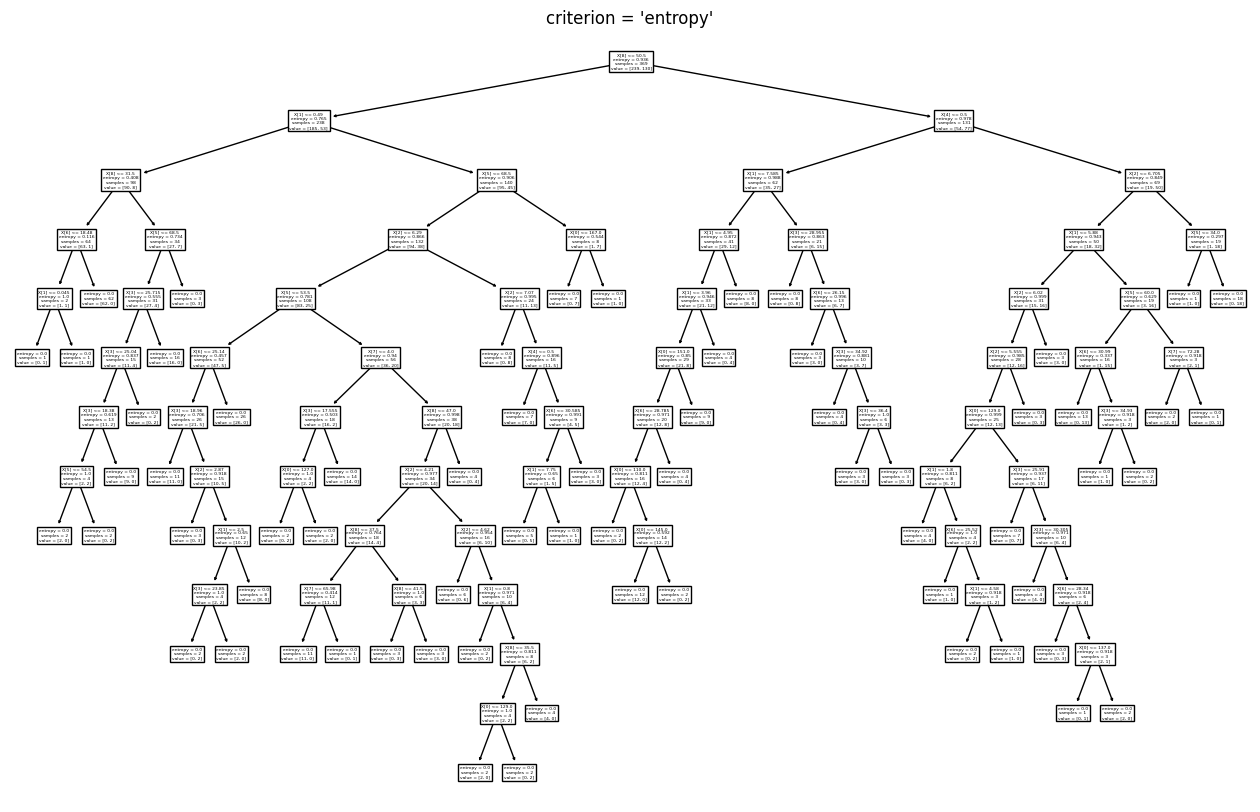

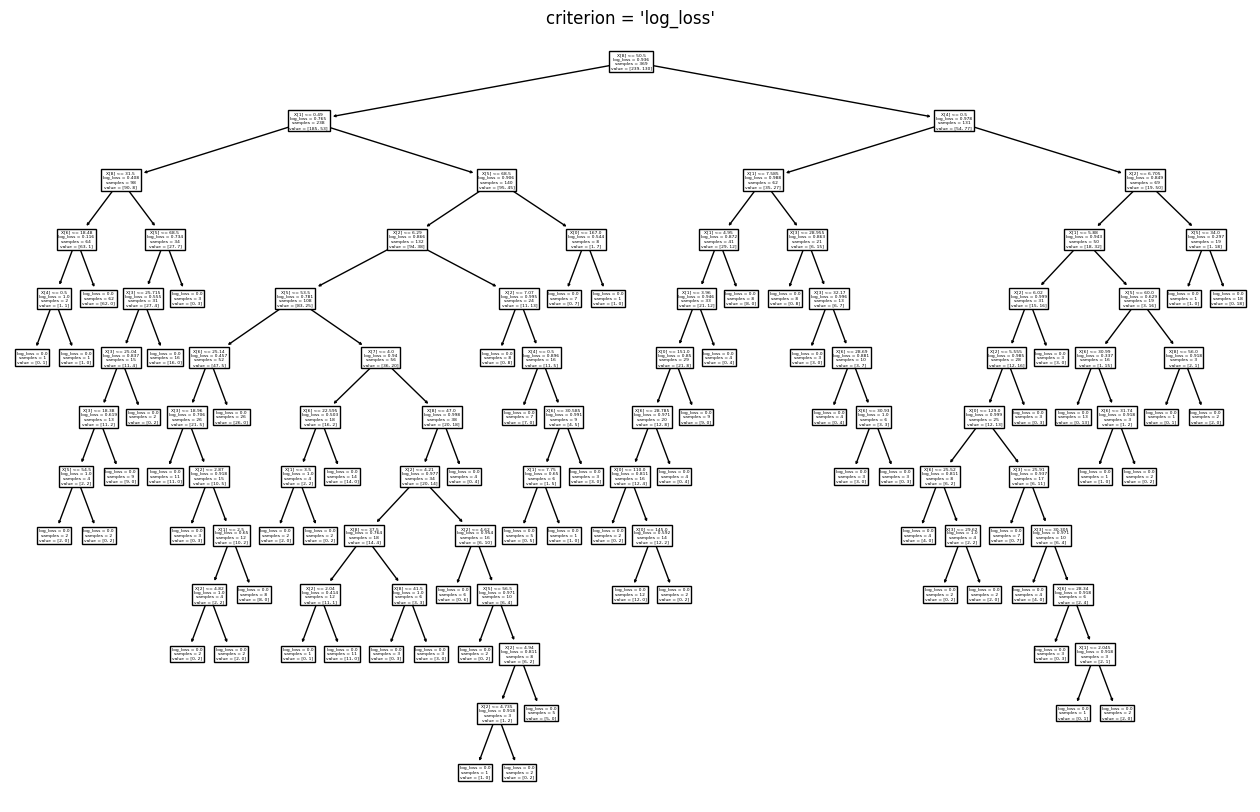

In [9]:
criterions = ["gini", "entropy", "log_loss"]

for criterion in criterions:
    dtc = DecisionTreeClassifier(criterion=criterion)
    dtc.fit(X_train_saheart, y_train_saheart)
    plt.figure(figsize=(16, 10))
    plot_tree(dtc)
    plt.title(f"{criterion = }")
    plt.show()

We can see that we have different splits when we are using different criterion. This diffrence is visible especially when we compare gini with the others

### Optimal tree using cost_complexity criterion

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

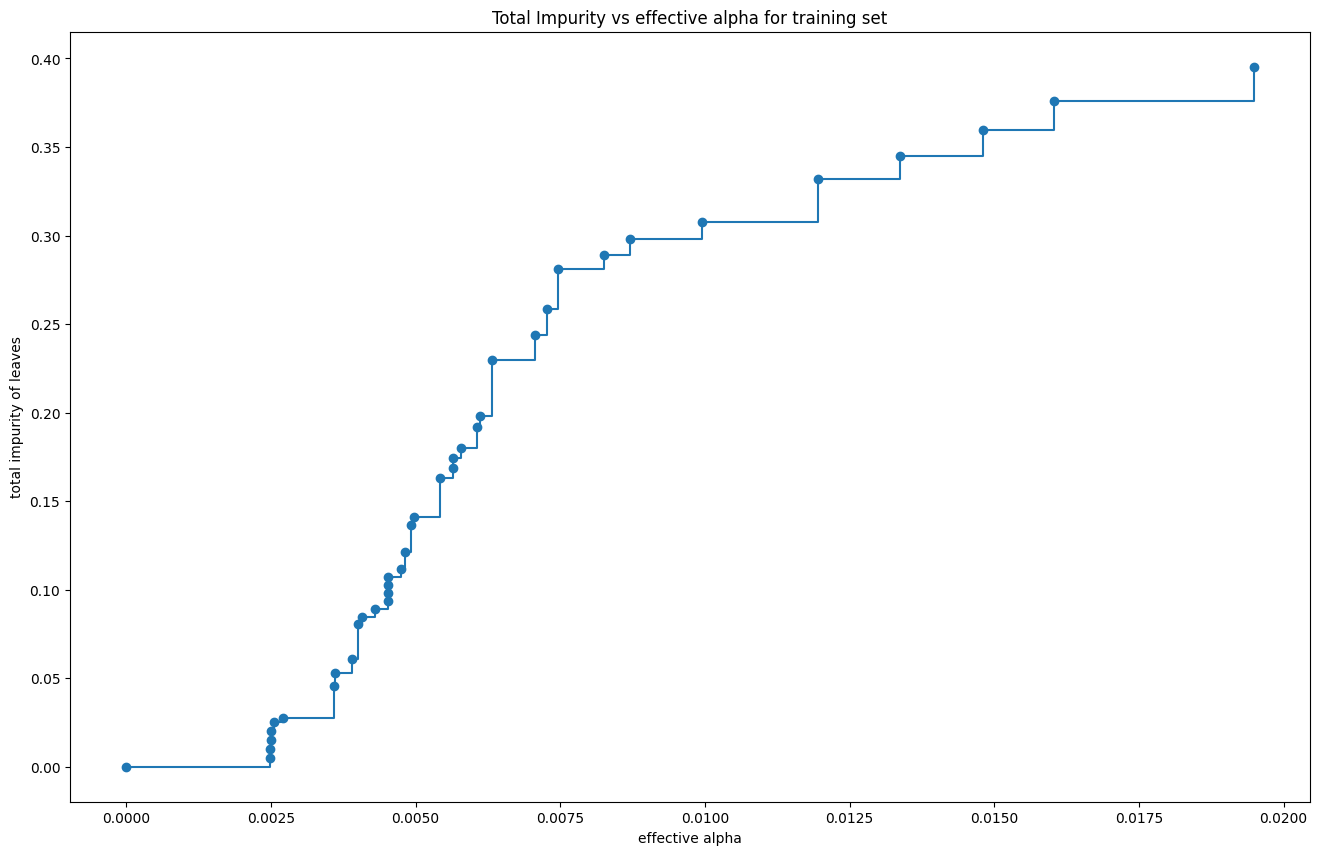

In [10]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train_saheart, y_train_saheart)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

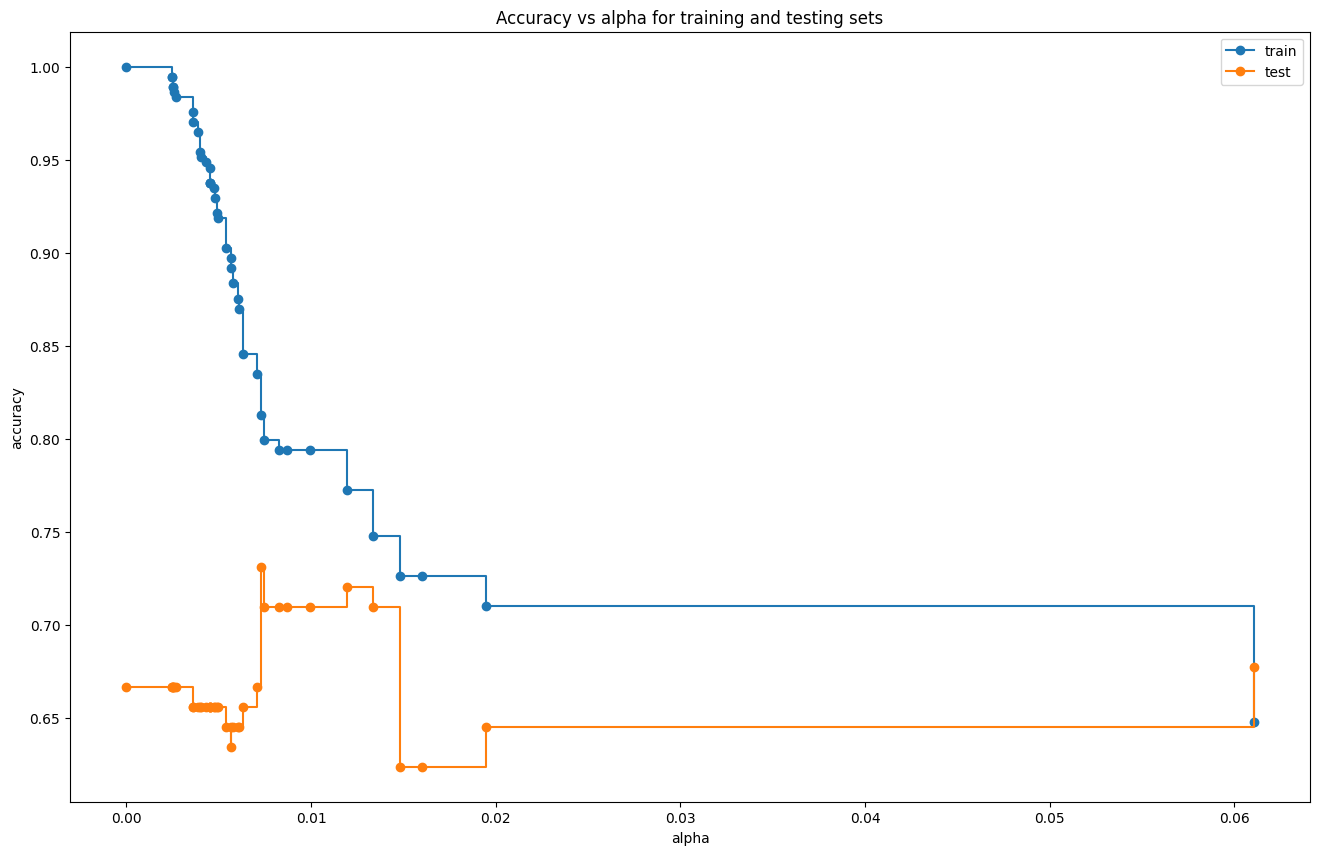

In [11]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_saheart, y_train_saheart)
    clfs.append(clf)

train_scores = [clf.score(X_train_saheart, y_train_saheart) for clf in clfs]
test_scores = [clf.score(X_test_saheart, y_test_saheart) for clf in clfs]

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

We can see that trees with alpha between 0 and 0.01 are definietely to complex. I decided to choose alpha equal to 0.02 because tree with this value maximize test accuracy

## DecisionTreeRegressor

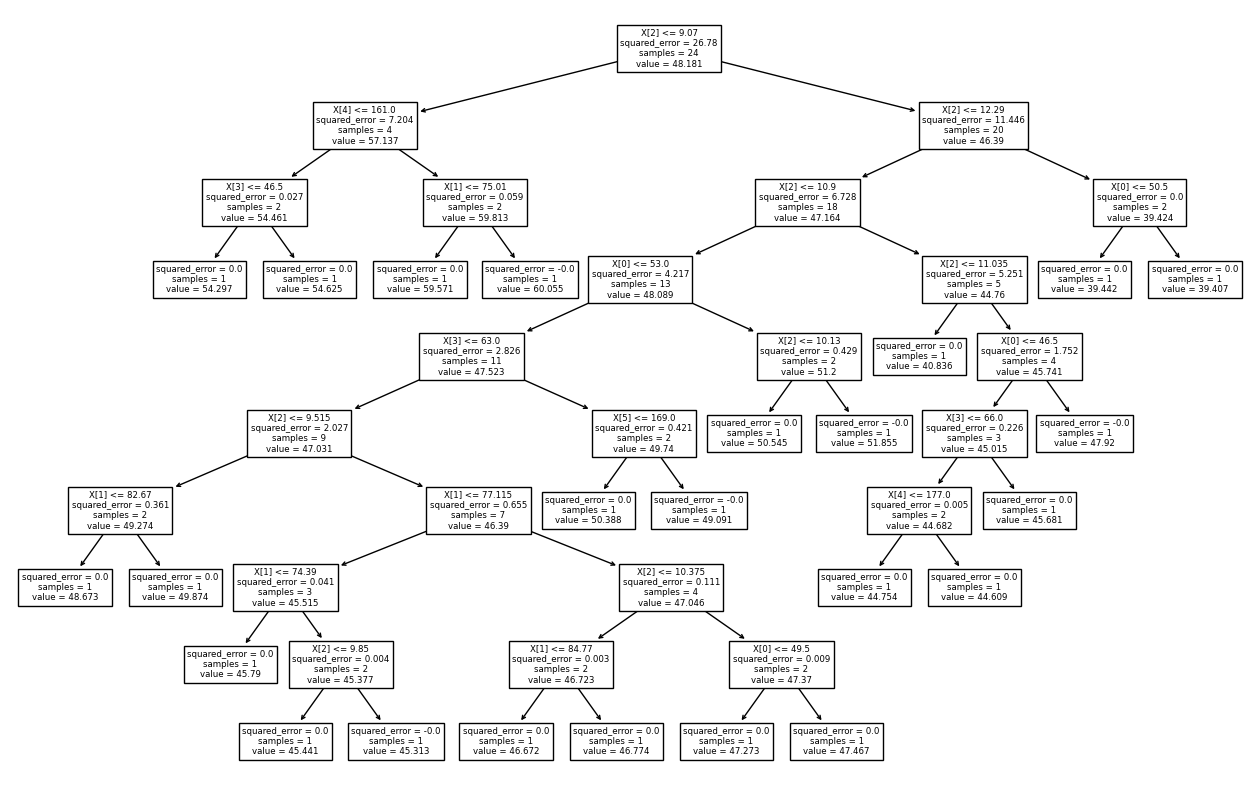

In [12]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train_fitness, y_train_fitness)
plt.figure(figsize=(16, 10))
plot_tree(dtr)
plt.show()

#### For which runner oxygen consumption is assesed as the highest?

In [13]:
print(f"Answer: {np.argmax(dtr.predict(X_fitness))}")

Answer: 20


#### Prediction for typical runner

In [14]:
typical_runner = np.mean(X_fitness, axis=0)
colnames = typical_runner.index
print(f"Predicted oxygen: {dtr.predict(np.array(typical_runner).reshape(1, -1))[0]}")

Predicted oxygen: 47.273


#### Optimal tree

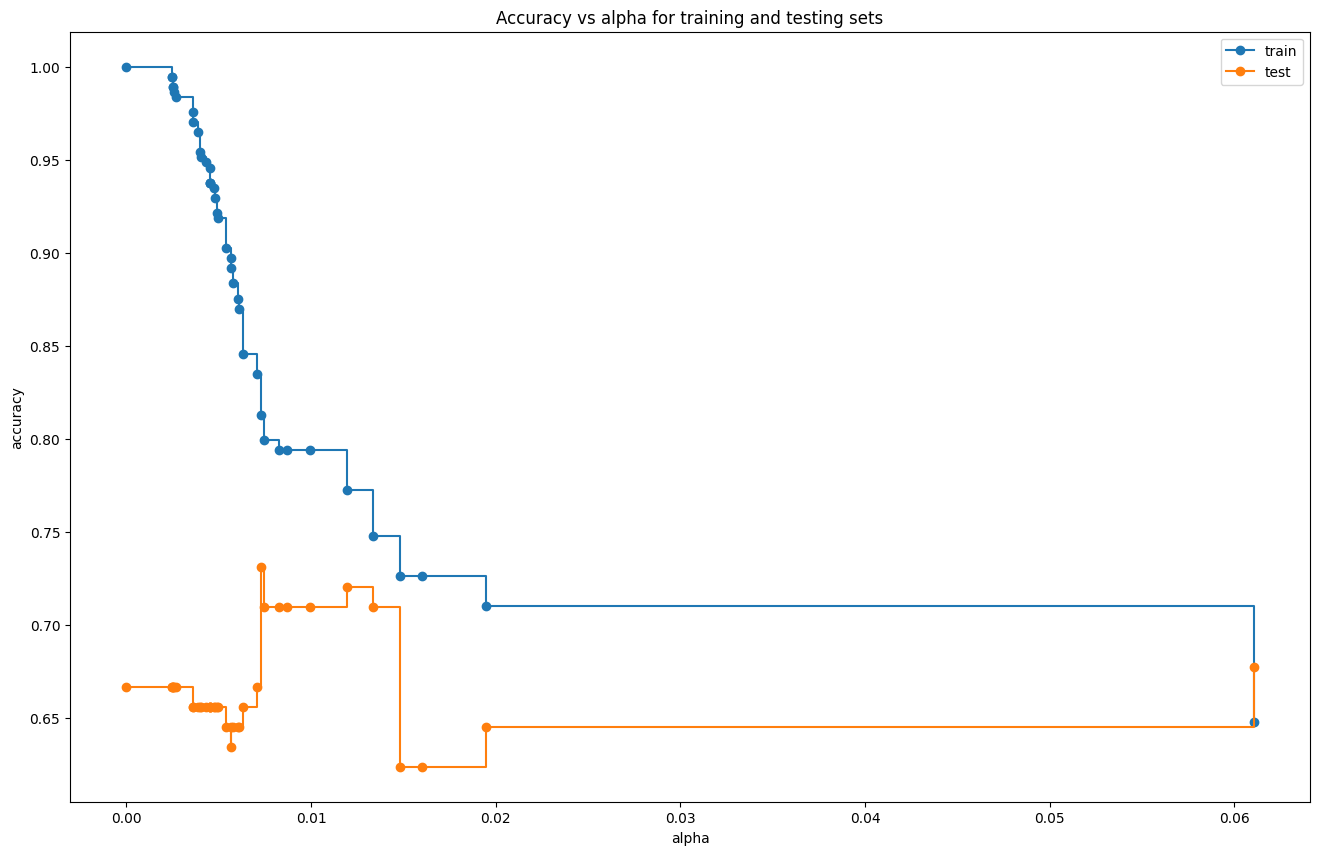

In [15]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train_saheart, y_train_saheart)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_saheart, y_train_saheart)
    clfs.append(clf)

train_scores = [clf.score(X_train_saheart, y_train_saheart) for clf in clfs]
test_scores = [clf.score(X_test_saheart, y_test_saheart) for clf in clfs]

fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Optimal tree is for alpha = 0.01

#### Model trained on two variables

In [16]:
import plotly.express as px

X_fitness_filtered = X_fitness.loc[:, ["RunTime", "Age"]]

dtr = DecisionTreeRegressor()
dtr.fit(X_fitness_filtered, y_fitness)

# data
RunTime = np.linspace(8, 12, 10)
Age = np.linspace(35, 60, 13)
cartesian_product = np.array(np.meshgrid(RunTime, Age)).T.reshape(-1,2)
Oxygen = dtr.predict(cartesian_product)

# plot
fig = px.scatter_3d(
    x=cartesian_product[:, 0], 
    y=cartesian_product[:, 1], 
    z=Oxygen, 
    labels={
        "x": "RunTime",
        "y": "Age",
        "z": "Oxygen"
    },
    width=1000, 
    height=800,
)

fig.update_traces(marker=dict(size=5,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(
    title={
        'text': "Oxygen depending on Age and RunTime",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

## Bagging algorithm

In [57]:
def bagging_single_tree(X, y, model, n_models, params={"max_depth": 3}, precision=3, iters=50):
    def _dominant(x):
        return np.bincount(x).argmax()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    metrics_bagging = [[], [], [], []]
    metrics_single_tree = [[], [], [], []]

    for _ in range(iters):
        predictions = []
        for i in range(n_models):
            X_train_resampled, y_train_resampled = resample(X_train, y_train, n_samples=X_train.shape[0])
            bagging = model(max_depth=params["max_depth"])
            bagging.fit(X_train_resampled, y_train_resampled)
            predictions.append(bagging.predict(X_test))

        single_tree = model(max_depth=params["max_depth"])
        single_tree.fit(X_train, y_train)
        
        predictions = np.array(predictions).T

        if isinstance(bagging, DecisionTreeClassifier):
            y_pred_bagging = np.apply_along_axis(_dominant, axis=1, arr=predictions)
            y_pred_single_tree = single_tree.predict(X_test)

            metrics_bagging[0].append(np.round(accuracy_score(y_test, y_pred_bagging), precision))
            metrics_bagging[1].append(np.round(precision_score(y_test, y_pred_bagging), precision))
            metrics_bagging[2].append(np.round(recall_score(y_test, y_pred_bagging), precision))
            metrics_bagging[3].append(np.round(f1_score(y_test, y_pred_bagging), precision))

            metrics_single_tree[0].append(np.round(accuracy_score(y_test, y_pred_single_tree), precision))
            metrics_single_tree[1].append(np.round(precision_score(y_test, y_pred_single_tree), precision))
            metrics_single_tree[2].append(np.round(recall_score(y_test, y_pred_single_tree), precision))
            metrics_single_tree[3].append(np.round(f1_score(y_test, y_pred_single_tree), precision))
        else:
            y_pred_bagging = np.apply_along_axis(np.mean, axis=1, arr=predictions)
            y_pred_single_tree = single_tree.predict(X_test)

            metrics_bagging[0].append(np.round(mean_squared_error(y_test, y_pred_bagging), precision))
            metrics_bagging[1].append(np  .round(mean_absolute_error(y_test, y_pred_bagging), precision))

            metrics_single_tree[0].append(np.round(mean_squared_error(y_test, y_pred_single_tree), precision))
            metrics_single_tree[1].append(np.round(mean_absolute_error(y_test, y_pred_single_tree), precision))    

    return metrics_bagging, metrics_single_tree

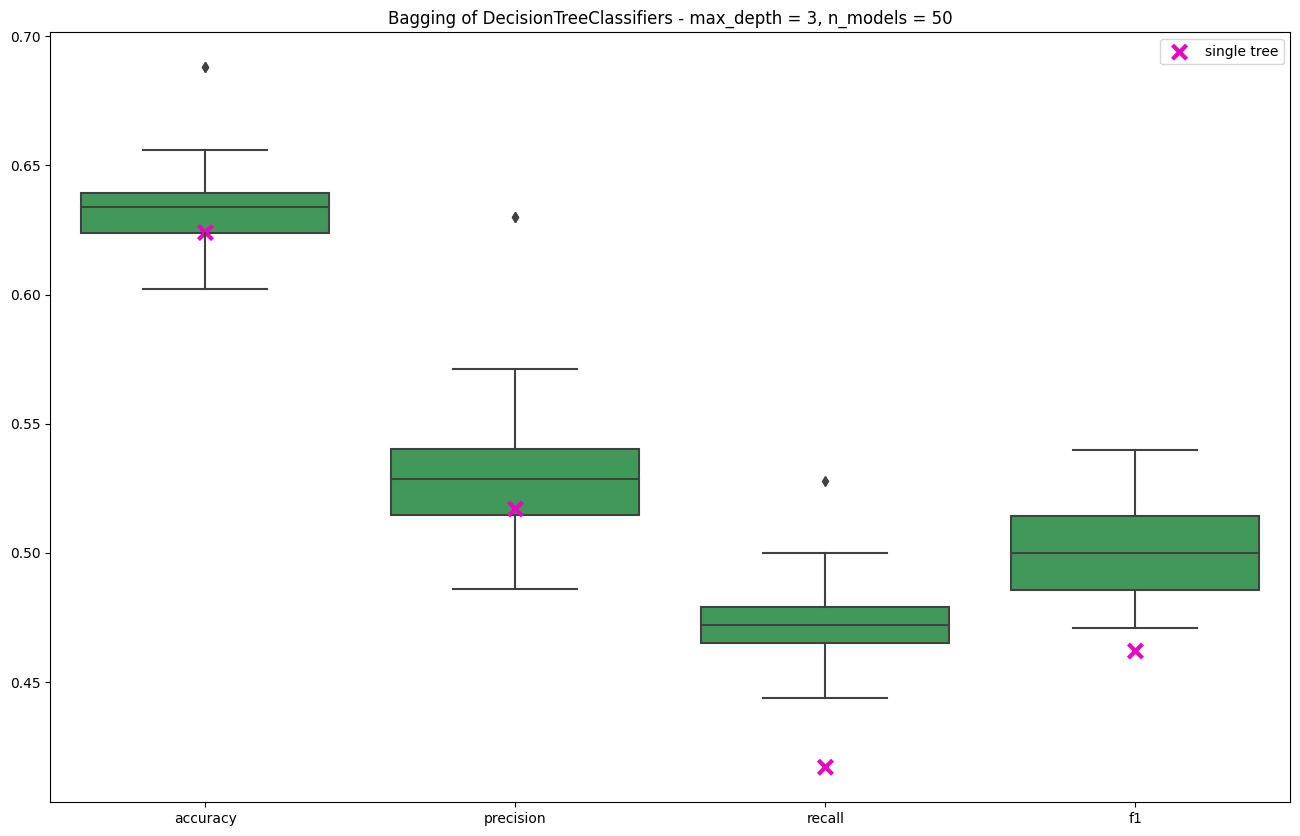

In [59]:
n_models = 50
max_depth = 3

metrics = bagging_single_tree(
    X_saheart, 
    y_saheart, 
    DecisionTreeClassifier,
    n_models=50,
    params={
        "max_depth": max_depth,
    }, 
    precision=3,
    iters=20,
)

df = pd.DataFrame(
    np.array(metrics[0]).T,
    columns=["accuracy", "precision", "recall", "f1"]
)

df2 = pd.DataFrame(
    np.array(metrics[1]).T,
    columns=["accuracy", "precision", "recall", "f1"]
)

f = plt.figure(figsize=(16, 10))

f = sns.boxplot(df, color="#32a852")
f = sns.pointplot(df2, markers="x", color="#e807bf", scale=1.5, linestyles="", label="single tree")

plt.legend()

plt.title(f"Bagging of DecisionTreeClassifiers - {max_depth = }, {n_models = }")
plt.show()

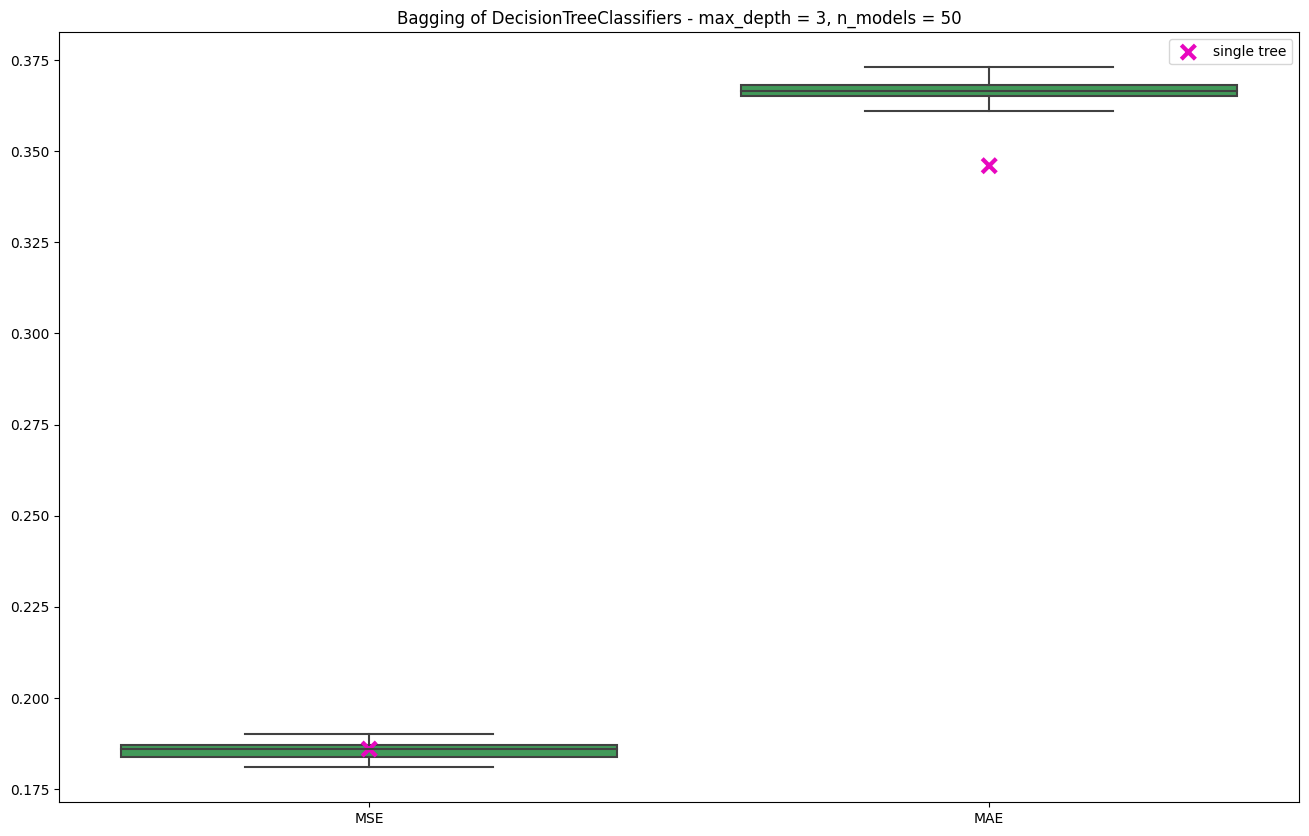

In [63]:
n_models = 50
max_depth = 3

metrics = bagging_single_tree(
    X_saheart, 
    y_saheart, 
    DecisionTreeRegressor,
    n_models=50,
    params={
        "max_depth": max_depth,
    }, 
    precision=3,
    iters=20,
)

df = pd.DataFrame(
    np.array(metrics[0][0:2]).T,
    columns=["MSE", "MAE"]
)

df2 = pd.DataFrame(
    np.array(metrics[1][0:2]).T,
    columns=["MSE", "MAE"]
)

f = plt.figure(figsize=(16, 10))

f = sns.boxplot(df, color="#32a852")
f = sns.pointplot(df2, markers="x", color="#e807bf", scale=1.5, linestyles="", label="single tree")

plt.legend()

plt.title(f"Bagging of DecisionTreeClassifiers - {max_depth = }, {n_models = }")
plt.show()